In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
import matplotlib.pylab as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split


In [22]:
!pip install pymystem3

In [23]:
pip install pymorphy3

In [24]:
pip install pymorphy2

In [25]:
from nltk.stem.snowball import SnowballStemmer
import pymorphy3
import pymorphy2
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [26]:
train = pd.read_csv('/content/train_candles.csv')
train = train.dropna().drop_duplicates()
train.head()

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,target_direction_20d
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,0.004896,1,0.071726,1
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,-0.010962,0,0.048477,1
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,-0.007635,0,0.048522,1
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,-0.014892,0,0.096550,1
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,0.044344,1,0.104056,1


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23118 entries, 0 to 23117
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  23118 non-null  float64
 1   close                 23118 non-null  float64
 2   high                  23118 non-null  float64
 3   low                   23118 non-null  float64
 4   volume                23118 non-null  int64  
 5   begin                 23118 non-null  object 
 6   ticker                23118 non-null  object 
 7   target_return_1d      23118 non-null  float64
 8   target_direction_1d   23118 non-null  int64  
 9   target_return_20d     23118 non-null  float64
 10  target_direction_20d  23118 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 1.9+ MB


In [28]:
candles = pd.read_csv('/content/candles.csv')
candles = candles.dropna().drop_duplicates()
candles.head()

,open,close,high,low,volume,begin,ticker
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT


Для горизонта 1 день:
target_return_1d - непрерывная доходность на 1 день вперед

target_direction_1d - бинарная направление движения (1 = рост, 0 = падение)

Для горизонта 20 дней:
target_return_20d - непрерывная доходность на 20 дней вперед

target_direction_20d - бинарная направление движения (1 = рост, 0 = падение)

In [29]:
train_text = pd.read_csv('/content/train_news.csv')
train_text=train_text.drop('Unnamed: 0', axis=1).dropna().drop_duplicates()
train_text.head()

,publish_date,title,publication
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл..."
3,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...
4,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...


работа с текстовыми данными



In [30]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""
    cleaned_text = re.sub(r'[^А-Яа-я\s]+', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

train_text['title'] = train_text['title'].apply(clean_text)
train_text['publication'] = train_text['publication'].apply(clean_text)
train_text.head(3)

,publish_date,title,publication
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли Ключевые российские нефтег...
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли Ключевые российские сталел...
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,Председатель правления Газпрома Алексей Миллер...


In [32]:
# приведение заглавных букв к строчным
import nltk
nltk.download('punkt_tab')

train_text['title'] = train_text['title'].apply(lambda x: ' '.join(word_tokenize(x.lower())))
train_text['publication'] = train_text['publication'].apply(lambda x: ' '.join(word_tokenize(x.lower())))
train_text.head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,publish_date,title,publication
0,2020-01-01 14:00:00,ключевые российские нефтегазовые компании смот...,тенденции в отрасли ключевые российские нефтег...
1,2020-01-02 15:00:00,ммк выгодно отличает высокая экспозиция на вну...,тенденции в отрасли ключевые российские сталел...
2,2020-01-03 10:13:10,контракты на поставку газа в белоруссию и тран...,председатель правления газпрома алексей миллер...
3,2020-01-03 13:26:29,пао фосагро внеочередное общее собрание,дата и время воса дата фиксации дополнительная...
4,2020-01-03 13:44:03,пао ммк внеочередное общее собрание итоги,дата и время собрания дата фиксации дополнител...


In [33]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopword = stopwords.words("russian")
morph = Mystem()
stemmer = SnowballStemmer("russian")


def lemmatize_and_stem(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopword:
            token = token.strip()
            token = morph.lemmatize(token)[0]
            token = stemmer.stem(token)
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

<>:1: SyntaxWarning: invalid escape sequence '\]'
<>:1: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-607517100.py:1: SyntaxWarning: invalid escape sequence '\]'
  patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"


In [34]:
train_text['title'] = train_text['title'].astype(str)
train_text['publication'] = train_text['publication'].astype(str)
train_text['title'] = train_text['title'].apply(lemmatize_and_stem)
train_text['publication'] = train_text['publication'].apply(lemmatize_and_stem)

In [35]:
train_text.head()

,publish_date,title,publication
0,2020-01-01 14:00:00,"[ключев, российск, нефтегазов, компан, смотрет...","[тенденц, отрасл, ключев, российск, нефтегазов..."
1,2020-01-02 15:00:00,"[ммк, выгодн, отлича, высок, экспозиц, внутрен...","[тенденц, отрасл, ключев, российск, сталелитей..."
2,2020-01-03 10:13:10,"[контракт, поставк, газ, белорусс, транз, прод...","[председател, правлен, газпр, алекс, миллер, ч..."
3,2020-01-03 13:26:29,"[па, фосагр, внеочередн, общ, собран]","[дат, врем, вос, дат, фиксац, дополнительн, ин..."
4,2020-01-03 13:44:03,"[па, ммк, внеочередн, общ, собран, итог]","[дат, врем, собран, дат, фиксац, дополнительн,..."


In [36]:
train_text['title'] = train_text['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
train_text['publication'] = train_text['publication'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

print(train_text['title'].head())
print(train_text['publication'].head())
train_text['clean_text'] = train_text['title'] + " " + train_text['publication']

train_text['clean_text'] = train_text['clean_text'].str.strip()
train_text = train_text[train_text['clean_text'] != ""]

train_text = train_text[train_text['clean_text'].str.len() > 0]

docs = train_text['clean_text'].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)
X_text = vectorizer.fit_transform(docs)

print(f"Создано {X_text.shape[1]} TF-IDF признаков для {X_text.shape[0]} документов")




print("Типы данных:")
print(f"title: {type(train_text['title'].iloc[0])}")
print(f"publication: {type(train_text['publication'].iloc[0])}")
print("\nПримеры текстов:")
for i in range(3):
    print(f"Документ {i}: {train_text['clean_text'].iloc[i][:100]}...")

0    ключев российск нефтегазов компан смотрет выго...
1       ммк выгодн отлича высок экспозиц внутрен рынок
2       контракт поставк газ белорусс транз продля год
3                      па фосагр внеочередн общ собран
4                    па ммк внеочередн общ собран итог
Name: title, dtype: object
0    тенденц отрасл ключев российск нефтегазов комп...
1    тенденц отрасл ключев российск сталелитейн ком...
2    председател правлен газпр алекс миллер чрезвыч...
3    дат врем вос дат фиксац дополнительн информац ...
4    дат врем собран дат фиксац дополнительн информ...
Name: publication, dtype: object
Создано 5000 TF-IDF признаков для 24127 документов
Типы данных:
title: <class 'str'>
publication: <class 'str'>

Примеры текстов:
Документ 0: ключев российск нефтегазов компан смотрет выгодн относительн аналог тенденц отрасл ключев российск н...
Документ 1: ммк выгодн отлича высок экспозиц внутрен рынок тенденц отрасл ключев российск сталелитейн компан сох...
Документ 2: контракт поставк

In [37]:
# Создаем колонку date в обоих DataFrame
train_text['date'] = pd.to_datetime(train_text['publish_date']).dt.date
train['date'] = pd.to_datetime(train['begin']).dt.date

print("Колонки в train_text:", train_text.columns.tolist())
print("Колонки в train:", train.columns.tolist())
print("\nДиапазон дат в train_text:", train_text['date'].min(), "до", train_text['date'].max())
print("Диапазон дат в train:", train['date'].min(), "до", train['date'].max())

daily_news = train_text.groupby('date')['clean_text'].apply(lambda x: ' '.join(x)).reset_index()
#ВЕКТОРАЙЗЕР
daily_docs = daily_news['clean_text'].tolist()
daily_vectorizer = TfidfVectorizer(max_features=1000)
X_daily = daily_vectorizer.fit_transform(daily_docs)

daily_tfidf = pd.DataFrame(X_daily.toarray(), columns=daily_vectorizer.get_feature_names_out())
daily_tfidf['date'] = daily_news['date'].values

df = pd.merge(
    train,
    daily_tfidf,
    on='date',
    how='left'
)


print(f"Новостных фичей: {len([col for col in df.columns if not col in ['date', 'begin', 'ticker']])}")
df.shape

Колонки в train_text: ['publish_date', 'title', 'publication', 'clean_text', 'date']
Колонки в train: ['open', 'close', 'high', 'low', 'volume', 'begin', 'ticker', 'target_return_1d', 'target_direction_1d', 'target_return_20d', 'target_direction_20d', 'date']

Диапазон дат в train_text: 2020-01-01 до 2025-04-13
Диапазон дат в train: 2020-06-19 до 2025-04-15
Новостных фичей: 1009


(23118, 1012)

In [38]:
df.head()

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,...,эмитент,энергетическ,эт,этот,эффект,эффективн,юан,явля,январ,яндекс
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,0.004896,1,0.071726,...,0.036716,0.000000,0.115421,0.039197,0.021562,0.000000,0.0,0.013725,0.000000,0.131611
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,-0.010962,0,0.048477,...,0.040355,0.013494,0.049335,0.008616,0.011850,0.000000,0.0,0.045256,0.010421,0.013151
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,-0.007635,0,0.048522,...,0.030112,0.000000,0.032868,0.000000,0.000000,0.021662,0.0,0.014070,0.000000,0.000000
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,-0.014892,0,0.096550,...,0.045925,0.000000,0.030077,0.024514,0.061807,0.011013,0.0,0.042919,0.000000,0.361671
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,0.044344,1,0.104056,...,0.009139,0.030558,0.019951,0.029269,0.026835,0.000000,0.0,0.025622,0.000000,0.409492


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
import joblib

# Более простой и надежный подход - без группировки
df = df.fillna(0)

# Ценовые фичи
price_features = ['open', 'high', 'low', 'close', 'volume']

# Простые технические индикаторы (без группировки)
df['price_range'] = (df['high'] - df['low']) / df['close']  # диапазон цен
df['price_change'] = (df['close'] - df['open']) / df['open']  # изменение за день
df['volume_ratio'] = df['volume'] / df['volume'].rolling(5, min_periods=1).mean()  # объем относительно среднего

# Новостные фичи
news_features = daily_vectorizer.get_feature_names_out().tolist()

# Все фичи
all_features = price_features + ['price_range', 'price_change', 'volume_ratio'] + news_features

# Таргеты
targets = ['target_return_1d', 'target_return_20d', 'target_direction_1d', 'target_direction_20d']

print(f"Всего фичей: {len(all_features)}")
print(f"Таргеты: {targets}")
print(f"Размер датасета: {df.shape}")

Всего фичей: 1008
Таргеты: ['target_return_1d', 'target_return_20d', 'target_direction_1d', 'target_direction_20d']
Размер датасета: (23118, 1015)


In [40]:
# Сортируем по дате для временного разделения
df = df.sort_values('begin')

# Разделяем на train/validation (80%/20%)
split_idx = int(0.8 * len(df))
train_data = df.iloc[:split_idx].copy()
val_data = df.iloc[split_idx:].copy()

print(f"Train размер: {len(train_data)}")
print(f"Validation размер: {len(val_data)}")
print(f"Дата начала train: {train_data['begin'].min()}")
print(f"Дата окончания train: {train_data['begin'].max()}")
print(f"Дата начала validation: {val_data['begin'].min()}")
print(f"Дата окончания validation: {val_data['begin'].max()}")


X_train = train_data[all_features].fillna(0)
X_val = val_data[all_features].fillna(0)

# Таргеты для train
y_train_1d = train_data['target_return_1d']
y_train_20d = train_data['target_return_20d']
y_train_dir_1d = train_data['target_direction_1d']
y_train_dir_20d = train_data['target_direction_20d']

# Таргеты для validation
y_val_1d = val_data['target_return_1d']
y_val_20d = val_data['target_return_20d']
y_val_dir_1d = val_data['target_direction_1d']
y_val_dir_20d = val_data['target_direction_20d']

Train размер: 18494
Validation размер: 4624
Дата начала train: 2020-06-19
Дата окончания train: 2024-05-20
Дата начала validation: 2024-05-20
Дата окончания validation: 2025-04-15


In [41]:
!pip install lightgbm --upgrade


In [42]:
# # Модель для доходности на 1 день
# model_1d = lgb.LGBMRegressor(
#     n_estimators=200,
#     learning_rate=0.05,
#     random_state=42,
#     objective='regression'
# )
# model_1d.fit(X_train, y_train_1d)

# # Модель для доходности на 20 дней
# model_20d = lgb.LGBMRegressor(
#     n_estimators=200,
#     learning_rate=0.05,
#     random_state=42,
#     objective='regression'
# )
# model_20d.fit(X_train, y_train_20d)

# # Модель для направления на 1 день
# model_dir_1d = lgb.LGBMClassifier(
#     n_estimators=100,
#     learning_rate=0.05,
#     random_state=42
# )
# model_dir_1d.fit(X_train, y_train_dir_1d)

# # Модель для направления на 20 дней
# model_dir_20d = lgb.LGBMClassifier(
#     n_estimators=100,
#     learning_rate=0.05,
#     random_state=42
# )
# model_dir_20d.fit(X_train, y_train_dir_20d)
# Устанавливаем LightGBM с GPU поддержкой (если нужно)

import lightgbm as lgb

# Модель для доходности на 1 день с GPU
model_1d_gpu = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    objective='regression',
    device='gpu',  # ← ВКЛЮЧАЕМ GPU
    gpu_platform_id=0,
    gpu_device_id=0
)

# Модель для доходности на 20 дней с GPU
model_20d_gpu = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    objective='regression',
    device='gpu',  # ← ВКЛЮЧАЕМ GPU
    gpu_platform_id=0,
    gpu_device_id=0
)

# Модели для классификации с GPU
model_dir_1d_gpu = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42,
    device='gpu'  # ← ВКЛЮЧАЕМ GPU
)

model_dir_20d_gpu = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42,
    device='gpu'  # ← ВКЛЮЧАЕМ GPU
)

In [43]:

# Обучаем модели с GPU
model_1d_gpu.fit(X_train, y_train_1d)
print("Модель 1d обучена")

model_20d_gpu.fit(X_train, y_train_20d)
print("Модель 20d обучена")

model_dir_1d_gpu.fit(X_train, y_train_dir_1d)
print("Модель направления 1d обучена")

model_dir_20d_gpu.fit(X_train, y_train_dir_20d)
print("Модель направления 20d обучена")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 254960
[LightGBM] [Info] Number of data points in the train set: 18494, number of used features: 1008
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 785 dense feature groups (13.90 MB) transferred to GPU in 0.027729 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000600
✅ Модель 1d обучена
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 254960
[LightGBM] [Info] Number of data points in the train set: 18494, number of used features: 1008
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kern

In [44]:
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
import numpy as np

# Предсказания на validation
val_pred_1d = model_1d_gpu.predict(X_val)
val_pred_20d = model_20d_gpu.predict(X_val)
val_prob_1d = model_dir_1d_gpu.predict_proba(X_val)[:, 1]
val_prob_20d = model_dir_20d_gpu.predict_proba(X_val)[:, 1]

# Метрики для регрессии
mae_1d = mean_absolute_error(y_val_1d, val_pred_1d)
mae_20d = mean_absolute_error(y_val_20d, val_pred_20d)
rmse_1d = np.sqrt(mean_squared_error(y_val_1d, val_pred_1d))
rmse_20d = np.sqrt(mean_squared_error(y_val_20d, val_pred_20d))

# Метрики для классификации
acc_1d = accuracy_score(y_val_dir_1d, val_pred_1d > 0)
acc_20d = accuracy_score(y_val_dir_20d, val_pred_20d > 0)

# Brier score (для вероятностей)
brier_1d = np.mean((val_prob_1d - y_val_dir_1d) ** 2)
brier_20d = np.mean((val_prob_20d - y_val_dir_20d) ** 2)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ НА VALIDATION SET")
print("="*60)

print(f" ДОХОДНОСТЬ (Регрессия):")
print(f"MAE 1 день:     {mae_1d:.6f}")
print(f"MAE 20 дней:    {mae_20d:.6f}")
print(f"RMSE 1 день:    {rmse_1d:.6f}")
print(f"RMSE 20 дней:   {rmse_20d:.6f}")

print(f" НАПРАВЛЕНИЕ (Классификация):")
print(f"Accuracy 1 день:  {acc_1d:.4f}")
print(f"Accuracy 20 дней: {acc_20d:.4f}")
print(f"Brier 1 день:     {brier_1d:.4f}")
print(f"Brier 20 дней:    {brier_20d:.4f}")

# Сравнение с бейзлайном (предсказываем 0)
baseline_mae_1d = mean_absolute_error(y_val_1d, np.zeros_like(y_val_1d))
baseline_mae_20d = mean_absolute_error(y_val_20d, np.zeros_like(y_val_20d))
baseline_acc_1d = accuracy_score(y_val_dir_1d, np.zeros_like(y_val_dir_1d))

print(f"СРАВНЕНИЕ С БЕЙЗЛАЙНОМ (предсказание 0):")
print(f"Baseline MAE 1 день:  {baseline_mae_1d:.6f}")
print(f"Baseline MAE 20 дней: {baseline_mae_20d:.6f}")
print(f"Baseline Accuracy:    {baseline_acc_1d:.4f}")


📊 РЕЗУЛЬТАТЫ НА VALIDATION SET

🎯 ДОХОДНОСТЬ (Регрессия):
MAE 1 день:     0.016989
MAE 20 дней:    0.089182
RMSE 1 день:    0.023081
RMSE 20 дней:   0.110799

🎯 НАПРАВЛЕНИЕ (Классификация):
Accuracy 1 день:  0.5091
Accuracy 20 дней: 0.4403
Brier 1 день:     0.2574
Brier 20 дней:    0.2875

📈 СРАВНЕНИЕ С БЕЙЗЛАЙНОМ (предсказание 0):
Baseline MAE 1 день:  0.016656
Baseline MAE 20 дней: 0.081738
Baseline Accuracy:    0.5374


In [45]:
# Предположим, у нас есть тестовые данные (замени на свои реальные test данные)
# Если тестовых данных нет, используем val_data для демонстрации

# Для реального соревнования загрузи тестовые данные:
# test_candles = pd.read_csv('/content/public_test_candles.csv')
# test_candles['begin'] = pd.to_datetime(test_candles['begin'])
# test_candles['date'] = test_candles['begin'].dt.date

# Объединяем с новостными фичами (аналогично train)
# test_data = pd.merge(test_candles, daily_tfidf, on='date', how='left')

# Для демонстрации используем val_data
test_data = val_data.copy()

print(f" Размер тестовых данных: {test_data.shape}")

# Предсказания для теста
X_test = test_data[all_features].fillna(0)

test_pred_1d = model_1d_gpu.predict(X_test)
test_pred_20d = model_20d_gpu.predict(X_test)
test_prob_1d = model_dir_1d_gpu.predict_proba(X_test)[:, 1]
test_prob_20d = model_dir_20d_gpu.predict_proba(X_test)[:, 1]

# Создаем submission DataFrame
submission = test_data[['ticker', 'begin']].copy()
submission['pred_return_1d'] = test_pred_1d
submission['pred_return_20d'] = test_pred_20d
submission['pred_prob_up_1d'] = test_prob_1d
submission['pred_prob_up_20d'] = test_prob_20d

# Ограничиваем значения для стабильности
submission['pred_return_1d'] = submission['pred_return_1d'].clip(-0.1, 0.1)
submission['pred_return_20d'] = submission['pred_return_20d'].clip(-0.3, 0.3)
submission['pred_prob_up_1d'] = submission['pred_prob_up_1d'].clip(0.01, 0.99)
submission['pred_prob_up_20d'] = submission['pred_prob_up_20d'].clip(0.01, 0.99)

# Сохраняем submission
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\n SUBMISSION ФАЙЛ СОЗДАН: {submission_path}")
print(f"Размер submission: {submission.shape}")

print("\n ПЕРВЫЕ 10 СТРОК SUBMISSION:")
print(submission.head(10).to_string(index=False))

print(f"\n СТАТИСТИКА PREDICTION:")
print(f"pred_return_1d:  [{submission['pred_return_1d'].min():.4f}, {submission['pred_return_1d'].max():.4f}]")
print(f"pred_return_20d: [{submission['pred_return_20d'].min():.4f}, {submission['pred_return_20d'].max():.4f}]")
print(f"pred_prob_up_1d:  {submission['pred_prob_up_1d'].mean():.4f} ± {submission['pred_prob_up_1d'].std():.4f}")
print(f"pred_prob_up_20d: {submission['pred_prob_up_20d'].mean():.4f} ± {submission['pred_prob_up_20d'].std():.4f}")

📊 Размер тестовых данных: (4624, 1015)

✅ SUBMISSION ФАЙЛ СОЗДАН: submission.csv
📁 Размер submission: (4624, 6)

📋 ПЕРВЫЕ 10 СТРОК SUBMISSION:
ticker      begin  pred_return_1d  pred_return_20d  pred_prob_up_1d  pred_prob_up_20d
  MOEX 2024-05-20       -0.003612         0.000962         0.492842          0.528838
  LKOH 2024-05-20       -0.005387        -0.020426         0.405553          0.392421
  GMKN 2024-05-20       -0.004193        -0.002314         0.504701          0.485449
  SBER 2024-05-20       -0.001385        -0.019733         0.492842          0.498434
  VTBR 2024-05-20        0.001941         0.013926         0.480460          0.614603
  MGNT 2024-05-20       -0.007412        -0.035943         0.344273          0.363714
  SIBN 2024-05-20       -0.004292         0.007300         0.485629          0.517630
  PHOR 2024-05-20       -0.002900        -0.012820         0.472707          0.483072
  AFLT 2024-05-20       -0.000658        -0.002571         0.477081          0.4946

In [46]:
import joblib
import pickle

# Сохраняем модели
joblib.dump(model_1d_gpu, 'model_1d_gpu.pkl')
joblib.dump(model_20d_gpu, 'model_20d_gpu.pkl')
joblib.dump(model_dir_1d_gpu, 'model_dir_1d_gpu.pkl')
joblib.dump(model_dir_20d_gpu, 'model_dir_20d_gpu.pkl')

# Сохраняем векторaйзер
joblib.dump(daily_vectorizer, 'tfidf_vectorizer.pkl')

# Сохраняем список фичей
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(all_features, f)


✅ МОДЕЛИ И АРТЕФАКТЫ СОХРАНЕНЫ:
   - model_1d_gpu.pkl
   - model_20d_gpu.pkl
   - model_dir_1d_gpu.pkl
   - model_dir_20d_gpu.pkl
   - tfidf_vectorizer.pkl
   - feature_names.pkl



🔝 ТОП-20 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ 1 ДНЯ:


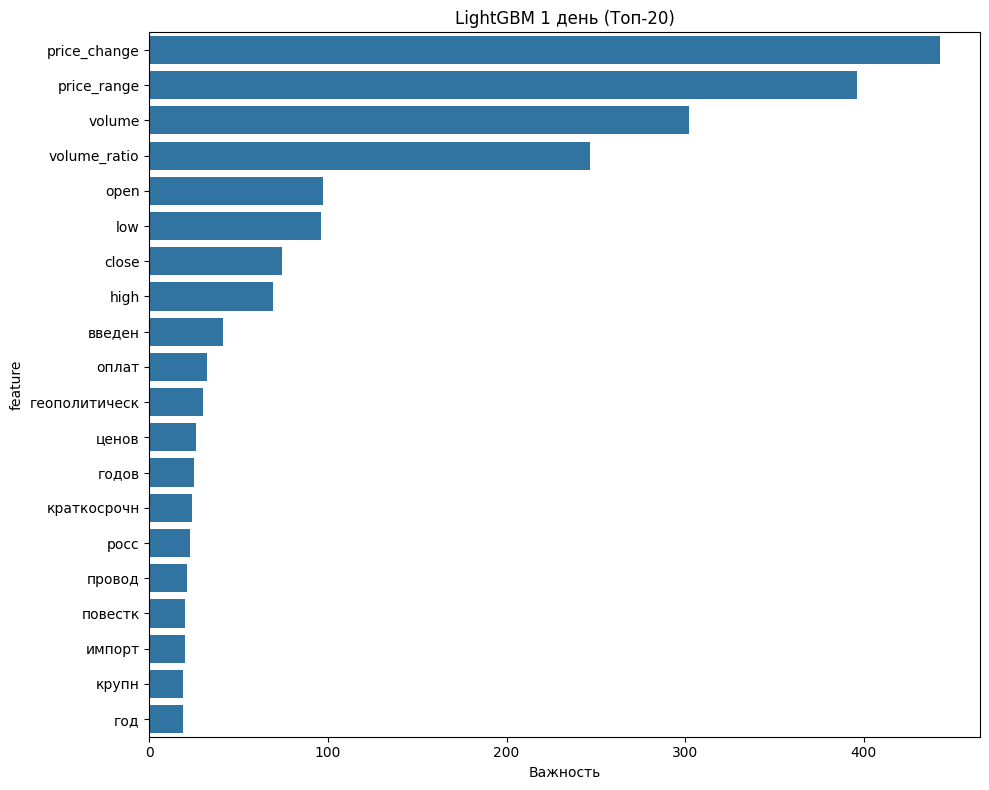

📰 Новостных фичей в топ-20: 12
Топ новостные фичи:
           feature  importance
56          введен          41
487          оплат          32
126  геополитическ          30
974          ценов          26
135          годов          25
314    краткосрочн          24
749           росс          23
663         провод          21
556        повестк          20
247         импорт          20
319          крупн          19
134            год          19


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для отображения важности признаков
def plot_feature_importance(model, feature_names, top_n=20, title="Важность признаков"):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, y='feature', x='importance')
    plt.title(f'{title} (Топ-{top_n})')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()

    return importance_df

# Важность признаков для модели 1 дня
print("\n ТОП-20 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ 1 ДНЯ:")
top_features_1d = plot_feature_importance(model_1d_gpu, all_features, title="LightGBM 1 день")

# Посмотрим, сколько новостных фичей в топе
news_in_top = top_features_1d[top_features_1d['feature'].isin(news_features)]
print(f"Новостных фичей в топ-20: {len(news_in_top)}")
if len(news_in_top) > 0:
    print("Топ новостные фичи:")
    print(news_in_top[['feature', 'importance']])